# Notebook for force analysis of Boltz-generated Langevin trajectories.
This notebook plots dot products between Boltz-predicted 'forces' \ 
(scores, up to a constant) and 'ground-truth forces' (forces computed \
using mm) to assess their agreement.

Requires:
- Boltz Langevin trajectory (hdf5) and topology (pdb)
- tleap installed

## Imports and preliminaries.

In [3]:
import mdtraj as md
import torch
from omm import ProteinImplicit
from tqdm import tqdm
import h5py
import openmm
import numpy as np
import subprocess
import os
import parmed as pmd
from openmm.app import *
import tempfile
import matplotlib.pyplot as plt
import glob
import shutil

a_to_nm = 0.1

In [4]:
def compute_force_from_traj(
    traj: md.Trajectory, 
    amber_filename:str, 
    num_relax_steps:int=0, 
    temperature:float=300
):
    """Compute the heavy atom forces at every trajectory frame.

    Parameters
    ----------
    traj : md.Trajectory
        Trajectory to compute forces for.
    amber_filename : str
        Name of the .prmtop and .(inp)crd files of the system.
    
    Notes
    -----
    Assumes kT units with T = 300 Kelvin unless otherwise specified.
    """    
    simulation_args = {
        "temperature": temperature, 
        "temperature_units": "kelvin", 
        "friction": 100.0, "dt": 0.00002, 
        "time_units": "picoseconds", 
        "prior_weight": None, 
        "integrator_to_use": "overdamped", 
        "do_energy_minimization": False, 
        "chk_freq": 10000000, 
        "device": "OpenCL", 
        "fix":"backbone"
    }
    solvent_args = {
        "implicit_solvent": "OBC2", 
        "implicit_solvent_kappa": 0.1, 
        "implicit_solvent_kappa_length_units": "nanometer"
    }

    p = ProteinImplicit(
        filename = amber_filename, chk=0,
        simulation_args=simulation_args,
        solvent_args=solvent_args,
        save_filename = f"./"
        )

    gen_positions = traj.xyz # mdtraj saves in nanometers by default
    final_forces = []

    for i, position in tqdm(enumerate(gen_positions), mininterval=10):
        # Need to somehow add hydrogens to each position tensor. 
        pos, pe, ke, forces = p.relax_energies(
            10 * position, # convert to angstroms
            velocities=True,
            num_relax_steps=num_relax_steps, # 0 relax steps means no relaxation, just get energies
            length_units="angstroms",
            time_units="picoseconds",
            energy_units="kT"
        )
        final_forces.append(forces)

    return np.stack(final_forces, axis=0)

## Seeing whether forces and scores agree for a Boltz Langevin trajectory.

### Calcuating mm ('ground truth') forces.

In [59]:
TOP_PATH = '/home/ethanz/boltz-likelihoods/predictions/boltz_results_pdb_test/predictions/chignolin/chignolin_model_0.pdb'
LANGEVIN_OUT = '/home/ethanz/boltz-likelihoods/predictions/boltz_results_chignolin_langevin_leps1e-6_lnoise1.0_stop180/trajectories/chignolin/traj_and_scores.h5'
STRIDE = 1000
temp_dir = tempfile.mkdtemp()

try:
    '''Step 1: Create mdtraj.Trajectory object(s) using Boltz Langevin outputs.'''
    final_trajs = []
    with h5py.File(LANGEVIN_OUT, 'r') as file:
        if "traj" not in file.keys():
            raise ValueError("No trajectory data in file")
        boltz_trajs = file["traj"][:]
        print('Input traj tensor shape: ', boltz_trajs.shape) # (n_steps, n_seeds, n_atoms, 3)
        boltz_trajs = [boltz_trajs[:, i, :, :] for i in range(boltz_trajs.shape[1])]
        num_trajs = len(boltz_trajs)

        boltz_topology = md.load(TOP_PATH).topology
        combined_traj = np.vstack(boltz_trajs)
        md_traj = md.Trajectory(
            (combined_traj * a_to_nm)[::STRIDE], # Ground truth positions are in angstroms.
            boltz_topology
        ).center_coordinates() # Avoid PDB column overflow.
        print('Final combined traj shape:', md_traj.xyz.shape)


    '''Step 2: Save a fixed PDB using tleap for every trajectory frame. A
    fixed PDB will have proper terminal residues and Hs. 
    '''
    for i, frame in tqdm(enumerate(md_traj), desc='Fixing Boltz PDBs', total=len(md_traj)):
        filename = os.path.join(temp_dir, f'frame_{i:04d}.pdb')
        fixed_filename = os.path.join(temp_dir, f'frame_{i:04d}_fixed.pdb')
        frame.save_pdb(filename)

        tleap_input = f"""
        source leaprc.ff99SBxildn
        mol = loadPDB {filename}
        savePdb mol {fixed_filename}
        quit
        """

        result = subprocess.run(
            ["tleap", "-f", "-"],  # "-" means read from stdin
            input=tleap_input.encode(),
            stdout=subprocess.DEVNULL,  # suppress normal output
            check=True
        )
            
    '''Step 3: Prepaing for compute_force_from_traj: reconstruct a 
    mdtraj.Trajectory using the fixed PDBs and generate amber files.'''
    pdbs = sorted(glob.glob(os.path.join(temp_dir, "frame_*_fixed.pdb")))   
    fixed_traj = md.load(pdbs)

    prmtop_savepath = os.path.join(temp_dir, 'a.prmtop')
    inpcrd_savepath = os.path.join(temp_dir, 'a.inpcrd')

    tleap_input = f"""
        source leaprc.ff99SBxildn
        mol = loadPDB {pdbs[0]}
        saveAmberParm mol {prmtop_savepath} {inpcrd_savepath}
        quit
        """

    result = subprocess.run(
        ["tleap", "-f", "-"],  # "-" means read from stdin
        input=tleap_input.encode(),
        stdout=subprocess.DEVNULL,  # suppress normal output
        check=True
    )

    '''Step 4: Running compute_force_from_traj and discarding forces on
    hydrogens/newly-added terminal atoms.'''
    forces = compute_force_from_traj(fixed_traj, os.path.join(temp_dir, 'a'))

    boltz_atoms = [str(atom) for atom in md_traj.topology.atoms]
    heavy_indices = []
    for i, atom in enumerate([str(atom) for atom in fixed_traj.topology.atoms]):
        if atom in boltz_atoms:
            heavy_indices.append(i)

    heavy_forces = forces[:, heavy_indices, :]

    # Removing tempdir files
    shutil.rmtree(temp_dir)
except Exception as e:    
    print(f'Error: {e}')
    print(f"Don't forget to remove the tempdir {temp_dir}.")

Input traj tensor shape:  (632534, 5, 92, 3)
Final combined traj shape: (3163, 92, 3)


Fixing Boltz PDBs.: 100%|██████████| 3163/3163 [05:00<00:00, 10.54it/s]
/home/ethanz/boltz-likelihoods/src/omm/omm.py:271: UserWarning: Check all Implicit solvent parameters (e.g. solvent)
  warnings.warn("Check all Implicit solvent parameters (e.g. solvent)")
/home/ethanz/boltz-likelihoods/.venv/lib/python3.12/site-packages/openmm/app/internal/amber_file_parser.py:1168: UserWarning: Non-optimal GB parameters detected for GB model OBC2
  warnings.warn(
3163it [00:30, 102.58it/s]


In [2]:
md_traj

NameError: name 'md_traj' is not defined

### Retrieve scores and plot dot products.

(3163, 92, 3) (3163, 92, 3)


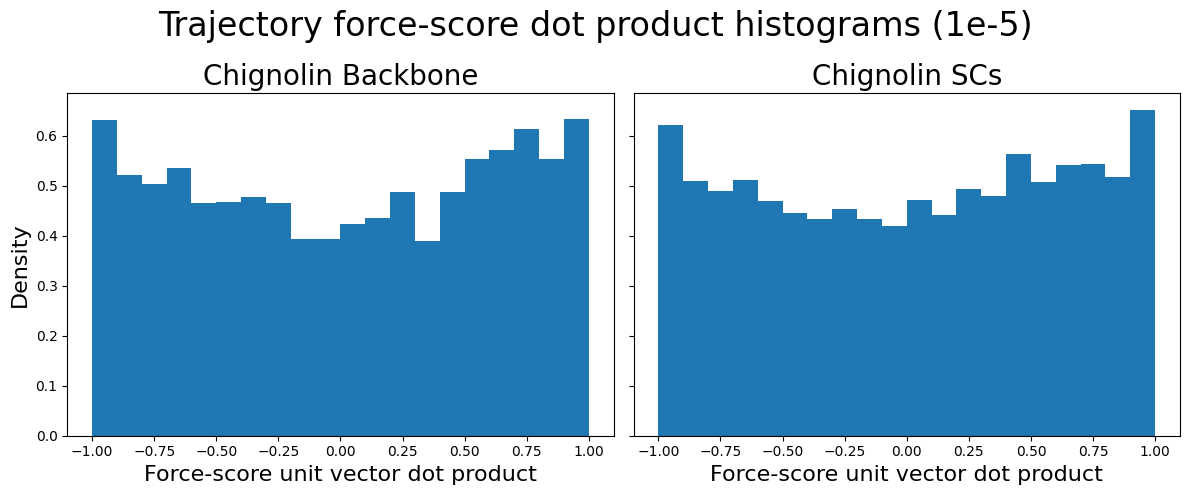

In [61]:
SAVE_PATH = '/home/ethanz/figs/chignolin_180stop_1e-5leps_backbonevssc.png'

with h5py.File(LANGEVIN_OUT, 'r') as file:
    if "scores" not in file.keys():
        raise ValueError("No score data in file")
    else:
        scores = file['scores'][:]

flattened_scores_shape = (scores.shape[0] * scores.shape[1],) + scores.shape[2:]
scores = scores.reshape(flattened_scores_shape)[::STRIDE]
print(scores.shape, md_traj.xyz.shape)

normed_scores = scores / (np.linalg.norm(scores, axis=-1, keepdims=True) + 1e-8)
normed_forces = heavy_forces / (np.linalg.norm(heavy_forces, axis=-1, keepdims=True) + 1e-8)
dot_products = np.sum(normed_scores * normed_forces, axis=-1)  # shape (n, m)

backbone_names = {'N', 'CA', 'C', 'O'}
backbone_indices = [i for i, atom in enumerate(boltz_atoms) if atom.split('-')[1] in backbone_names]
sc_indices = [i for i, atom in enumerate(boltz_atoms) if atom.split('-')[1] not in backbone_names]

mean_backbone_dps = dot_products[backbone_indices].flatten()
mean_sc_dps = dot_products[sc_indices].flatten()

fig, ax = plt.subplots(1,2, figsize=(12, 5), sharex=True, sharey=True)
ax[0].hist(mean_backbone_dps, bins=20, density=True)
ax[0].set_xlabel('Force-score unit vector dot product', fontsize=16)
ax[0].set_ylabel('Density', fontsize=16)
ax[0].set_title('Chignolin Backbone', fontsize=20)

ax[1].hist(mean_sc_dps, bins=20, density=True)
ax[1].set_xlabel('Force-score unit vector dot product', fontsize=16)
ax[1].set_title('Chignolin SCs', fontsize=20)

fig.suptitle('Trajectory force-score dot product histograms (1e-5)', fontsize=24)
plt.tight_layout()
# plt.savefig(SAVE_PATH)
plt.show()

### Finding the 'most important atoms' and plotting their force histograms.

Randomly picking $n$ frames and finding the top $x$ most 'important' \
(largest magnitude) atom forces in each frame. Then, these forces are \
normalized and dotted with their respective ground-truth mm force unit \
vector. Thus, in total, we will have $n \cdot x$ dot product values, \
which are plotted in a histogram.

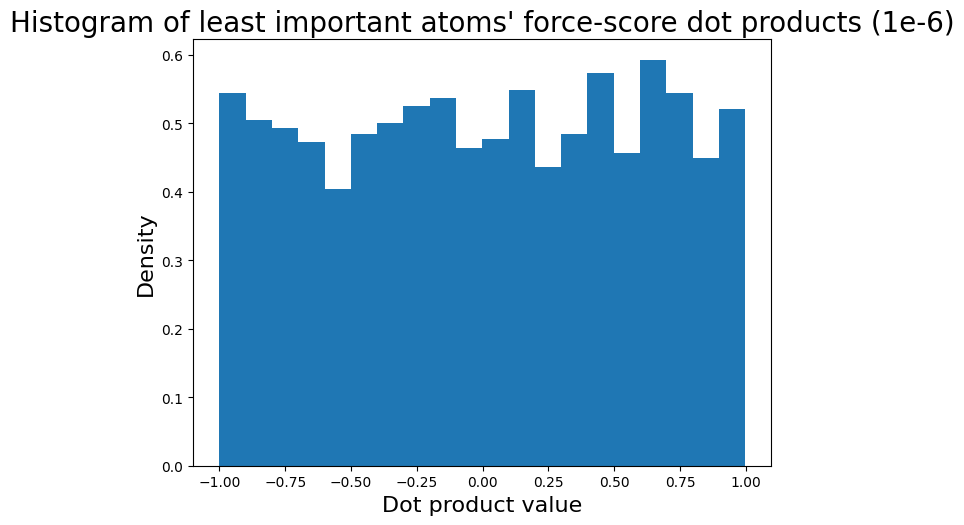

In [62]:
SAVE_PATH = '/home/ethanz/figs/chignolin_180stop_1e-6leps_worstdots.png'
n = 500
rand_indices = np.random.randint(0, heavy_forces.shape[0], size=n)

x = 5
data = []
for force_frame, dot_frame in zip(heavy_forces[rand_indices], dot_products[rand_indices]):
    frame_force_norms = np.linalg.norm(force_frame, axis=-1)
    topx_indices = np.argsort(frame_force_norms)[:x][::-1]

    top_dots = dot_frame[topx_indices] # Top forces' corresponding dot products.
    data.append(top_dots)

plt.hist(np.concatenate(data), bins=20, density=True)
plt.tight_layout()
plt.title("Histogram of least important atoms' force-score dot products (1e-6)", fontsize=20)
plt.xlabel("Dot product value", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.savefig(SAVE_PATH)
plt.show()

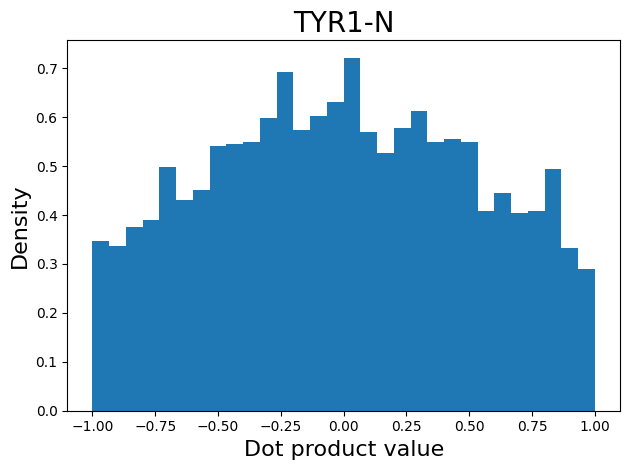

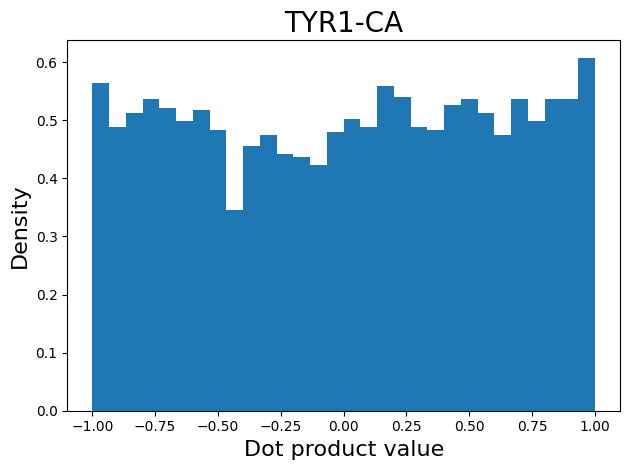

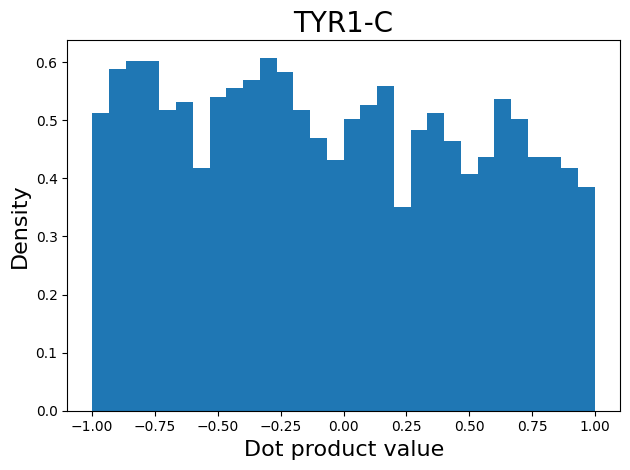

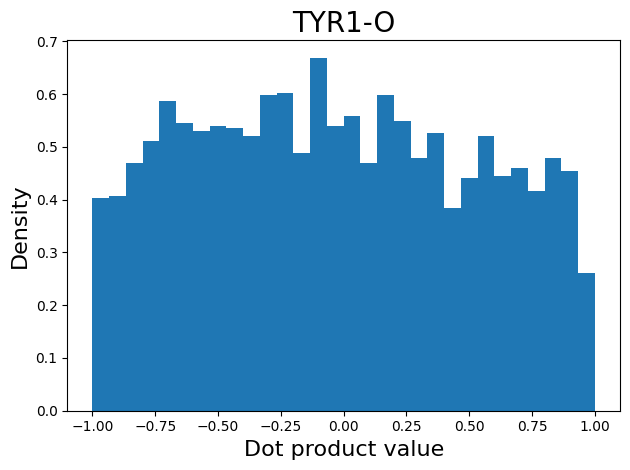

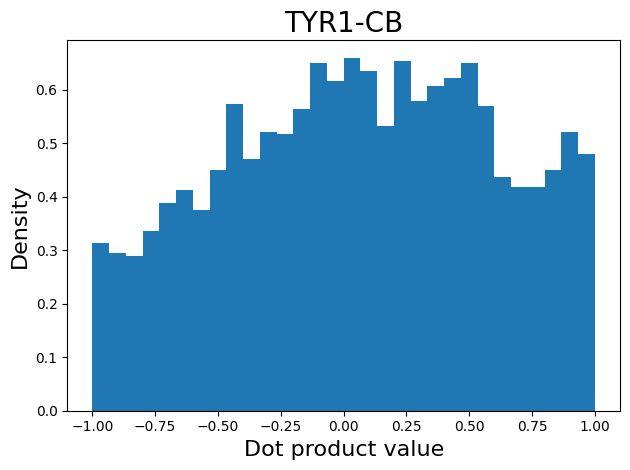

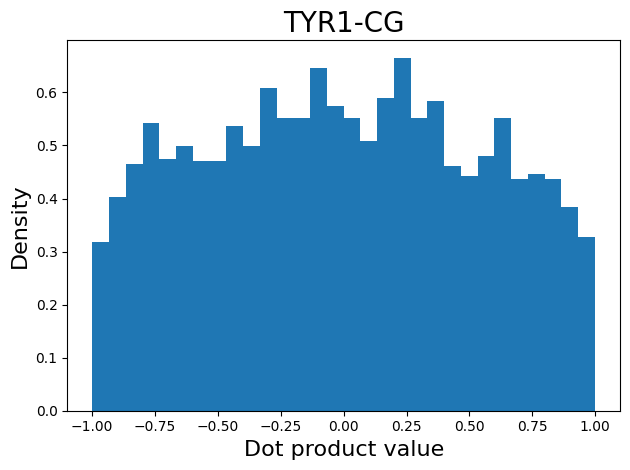

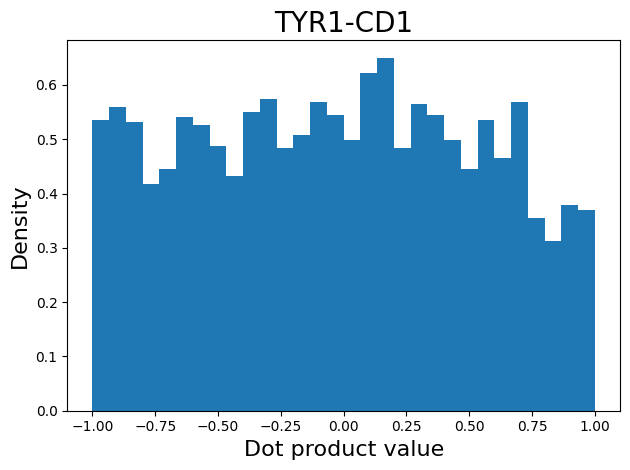

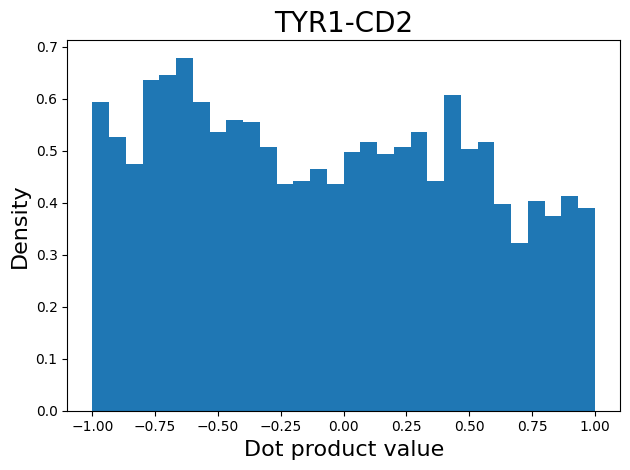

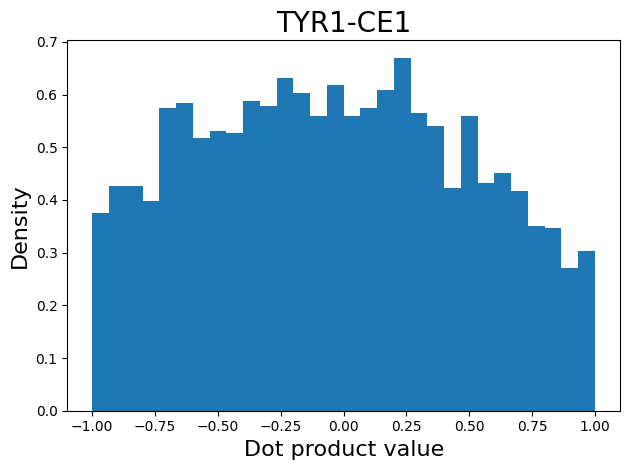

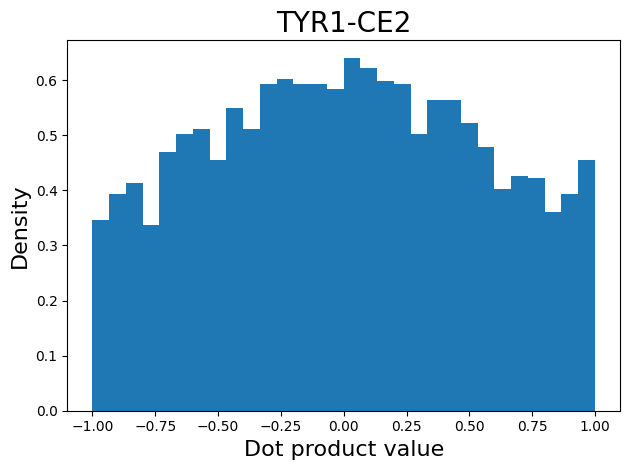

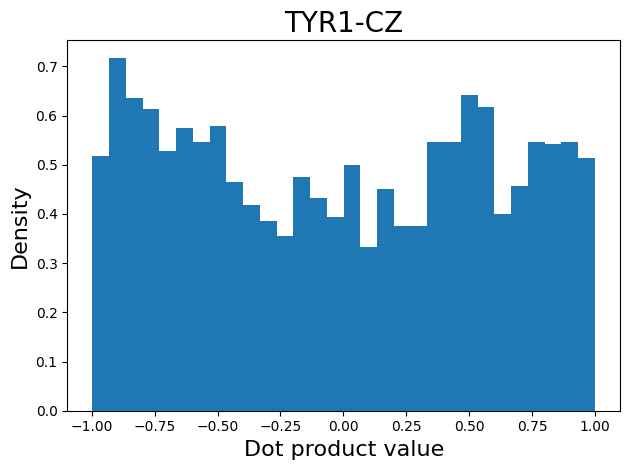

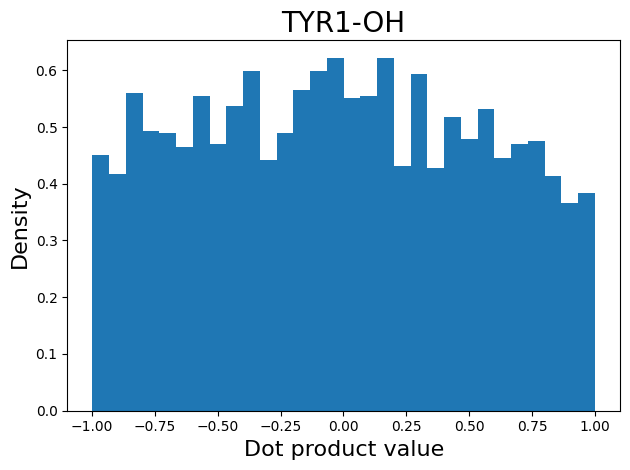

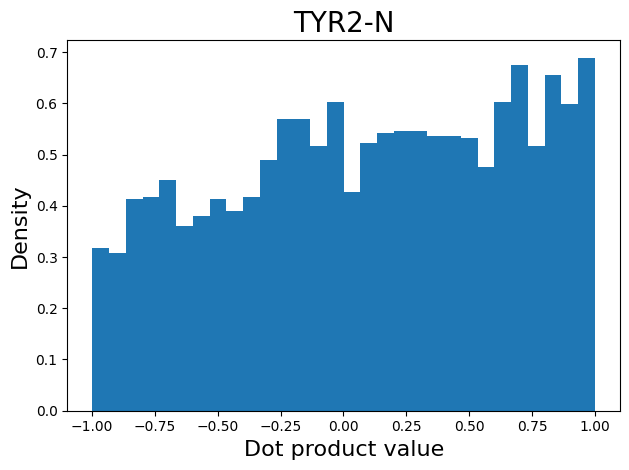

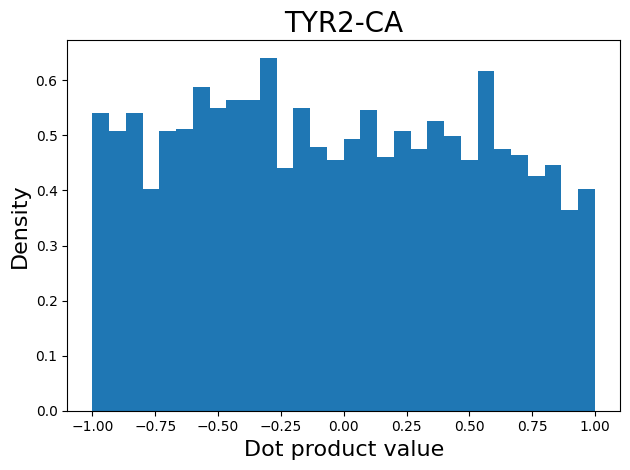

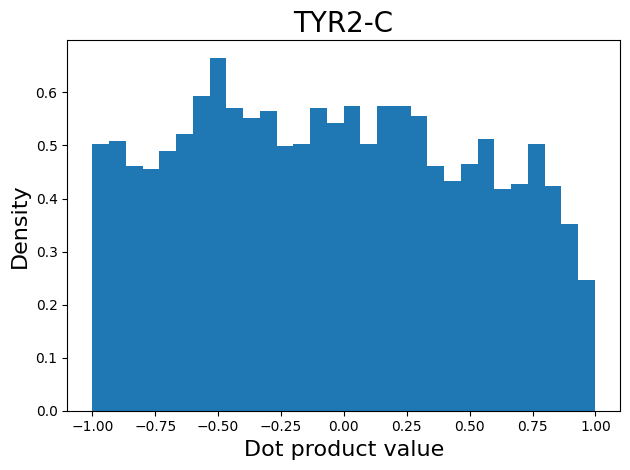

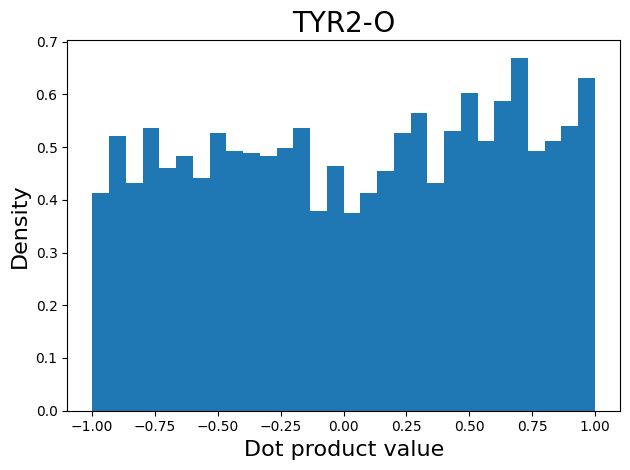

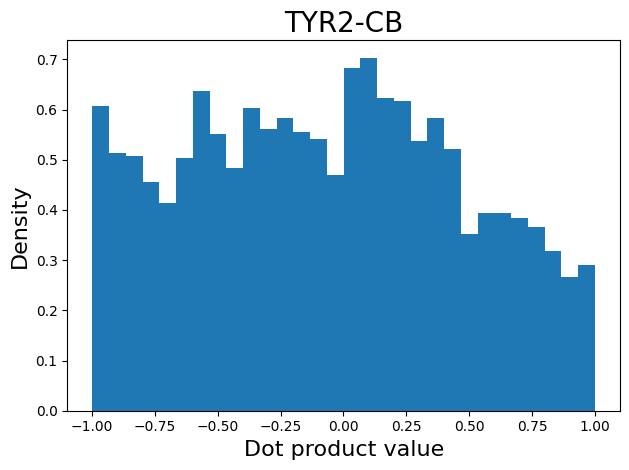

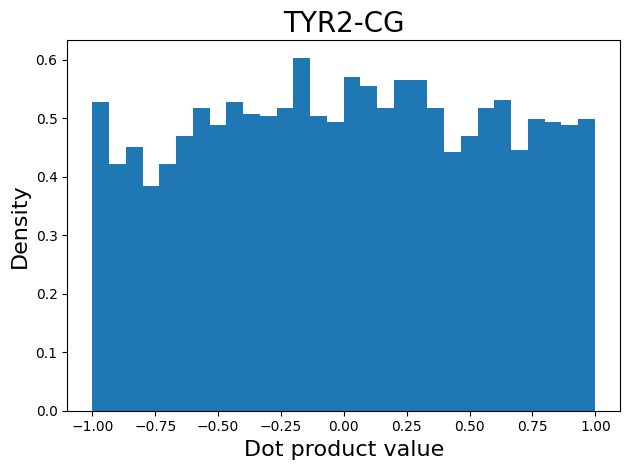

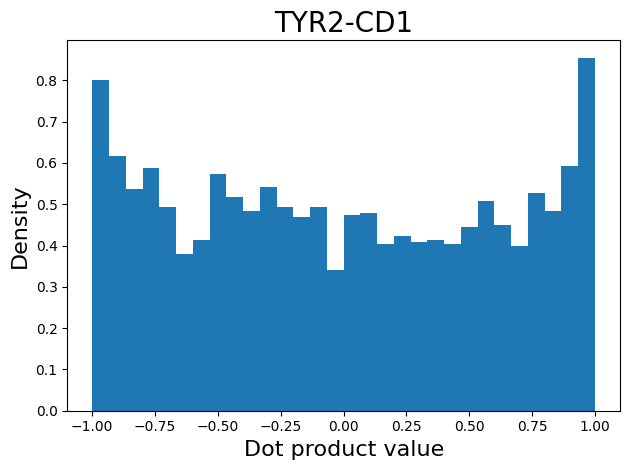

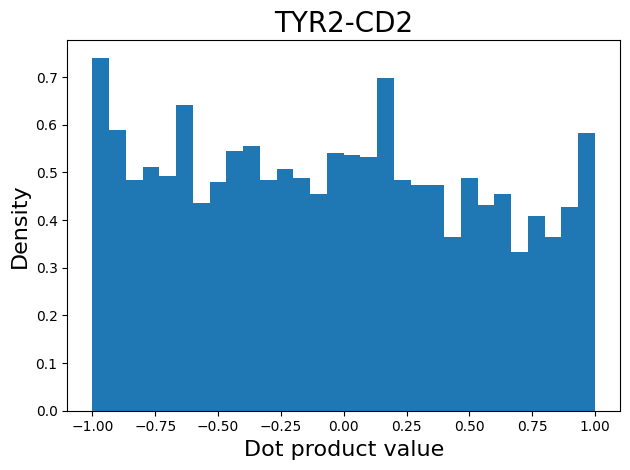

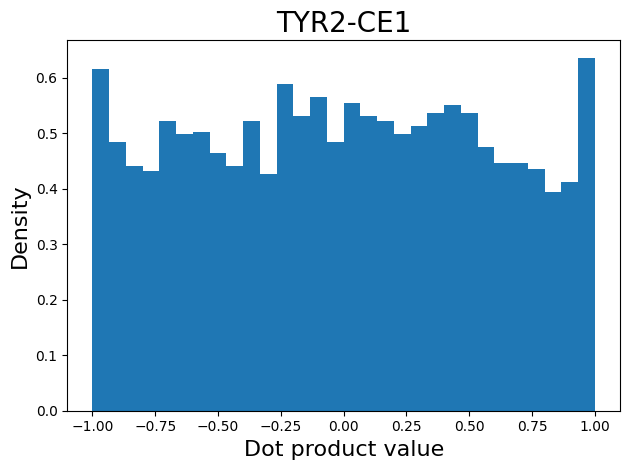

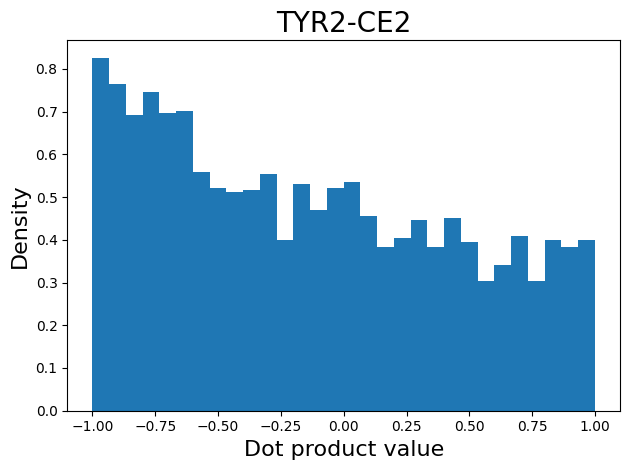

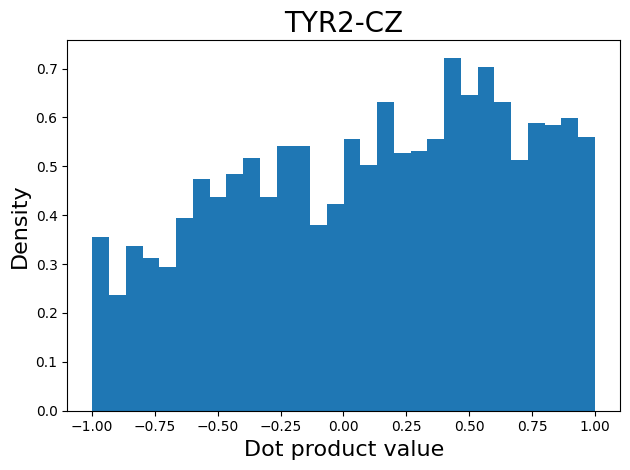

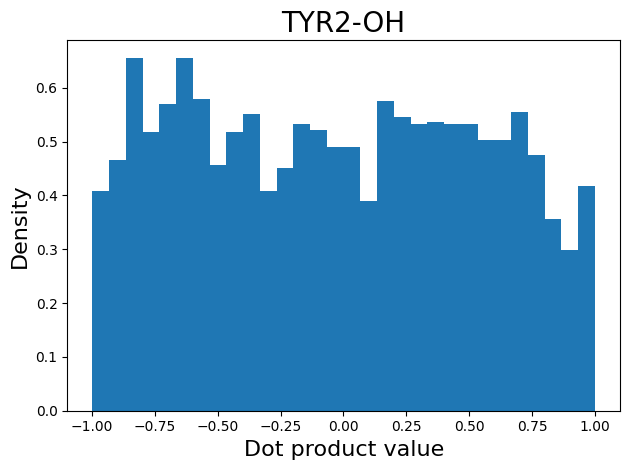

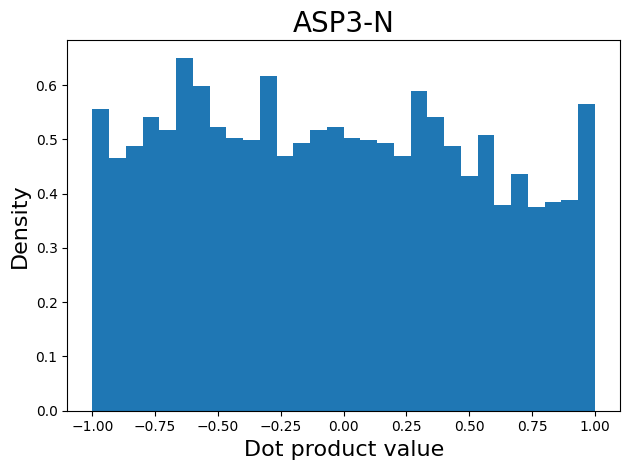

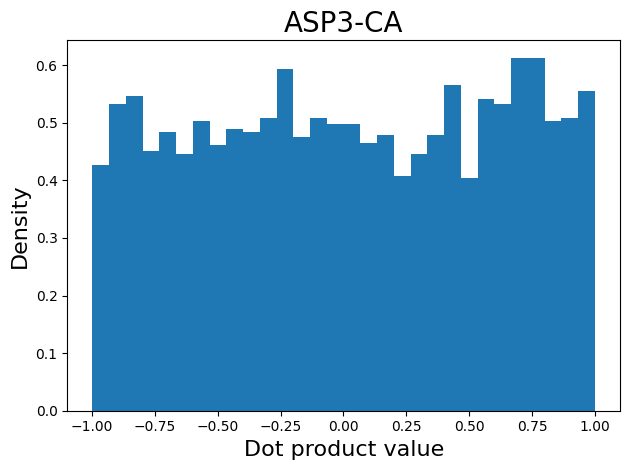

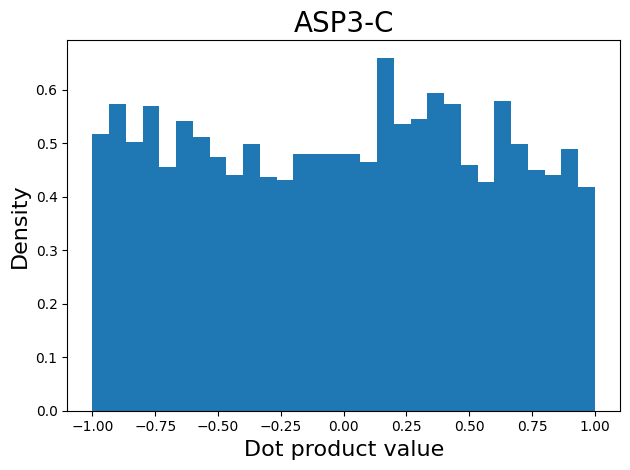

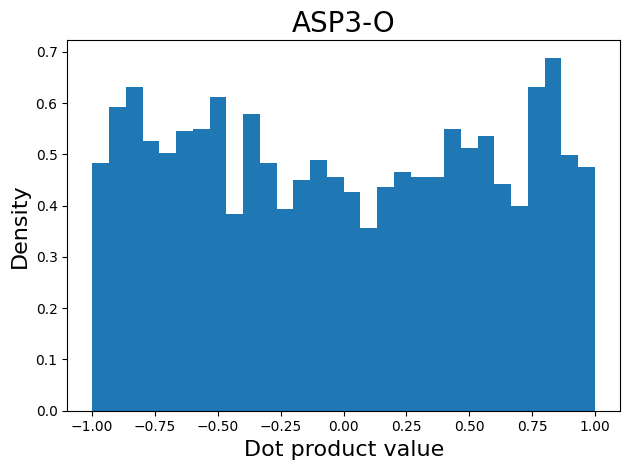

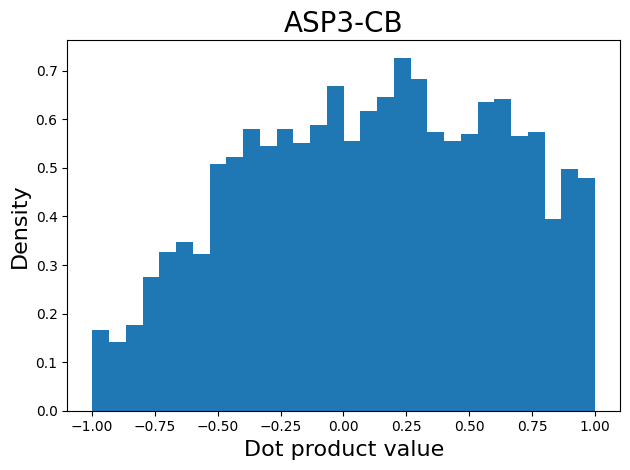

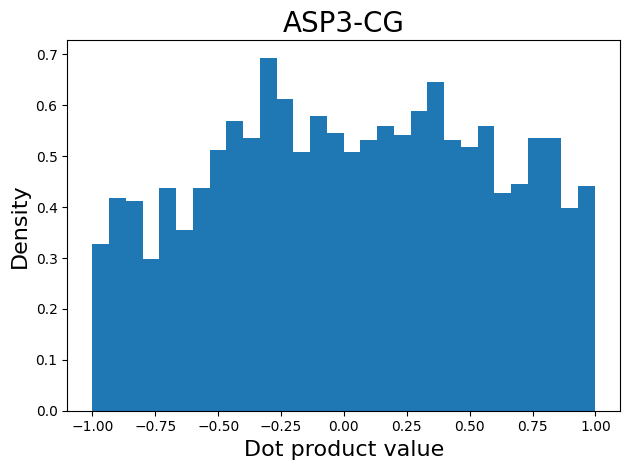

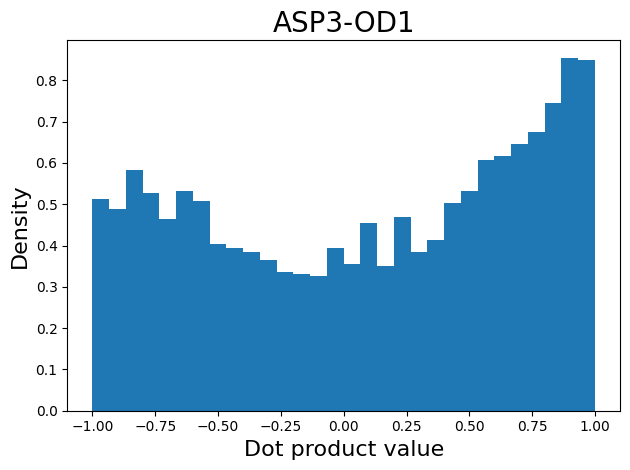

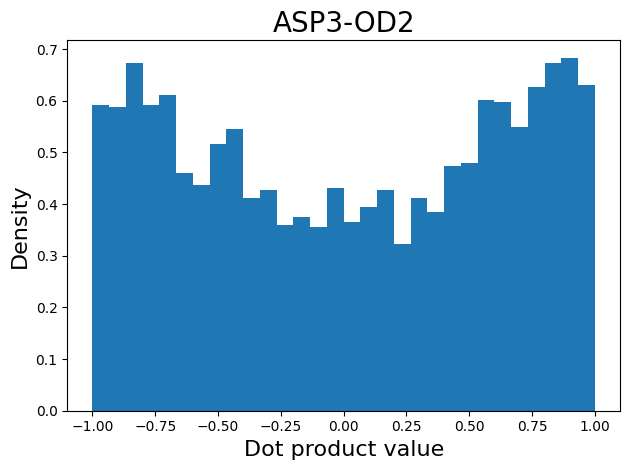

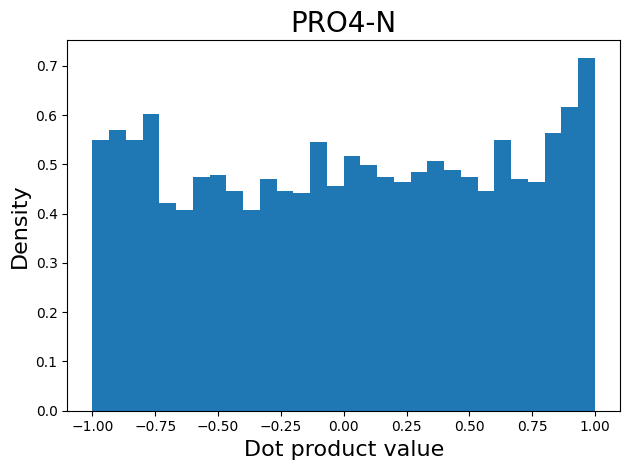

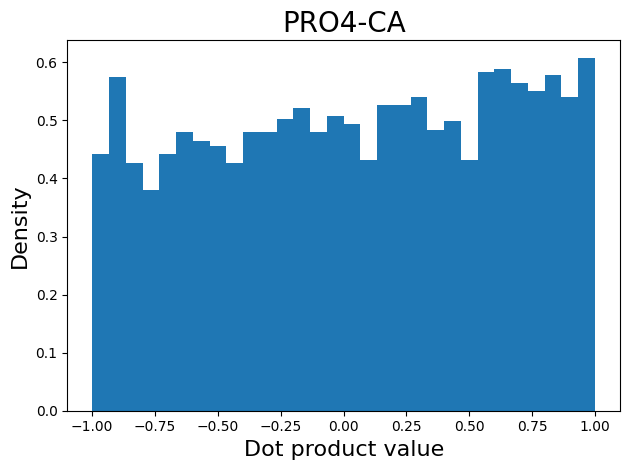

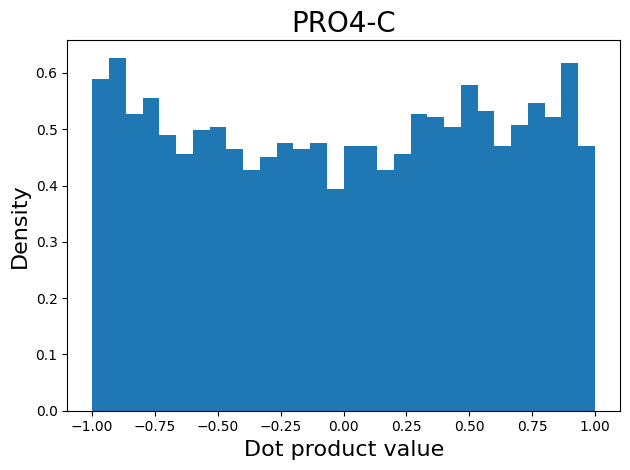

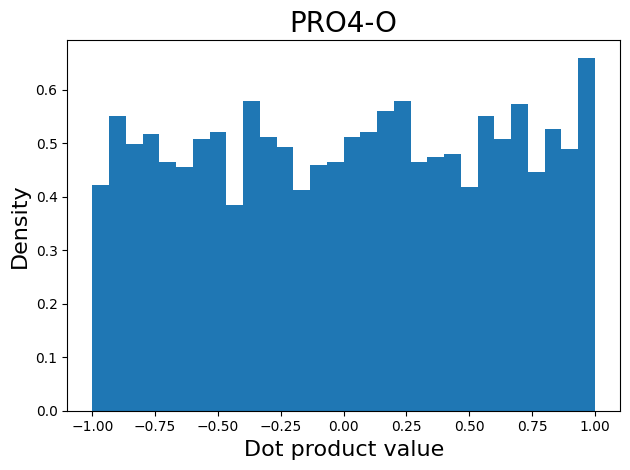

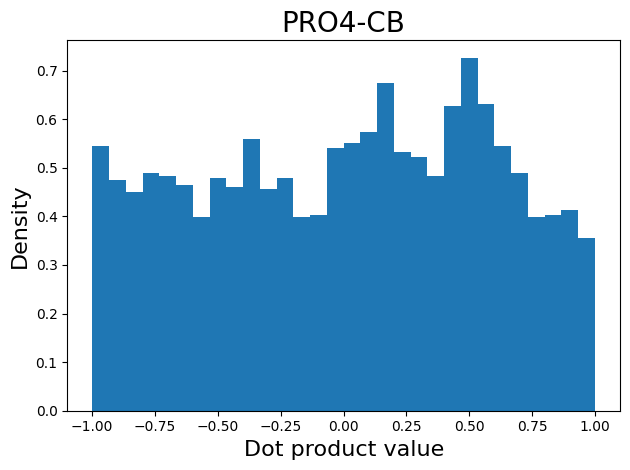

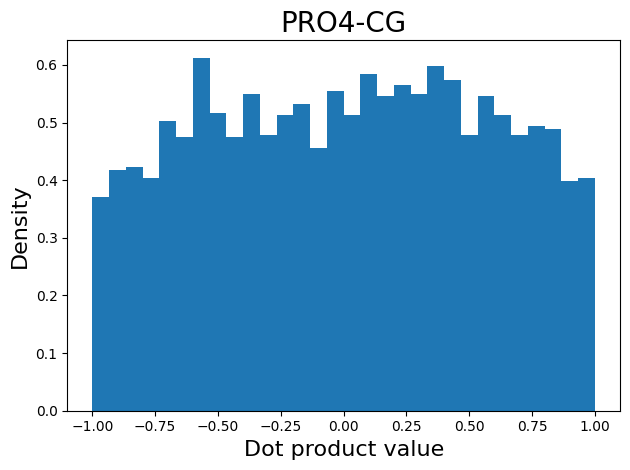

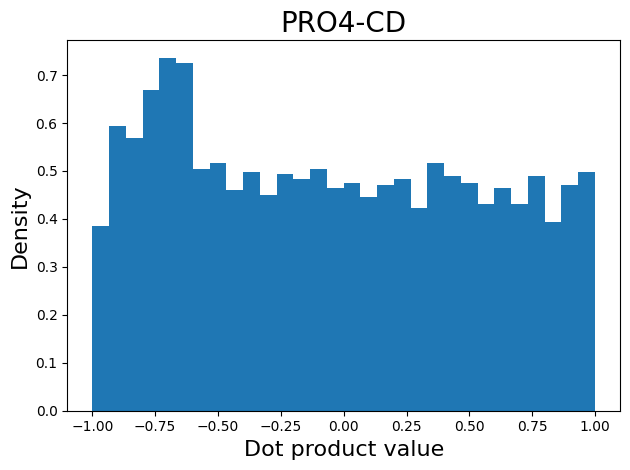

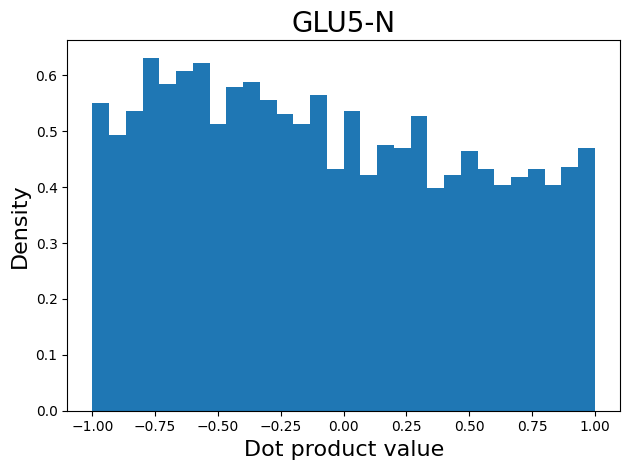

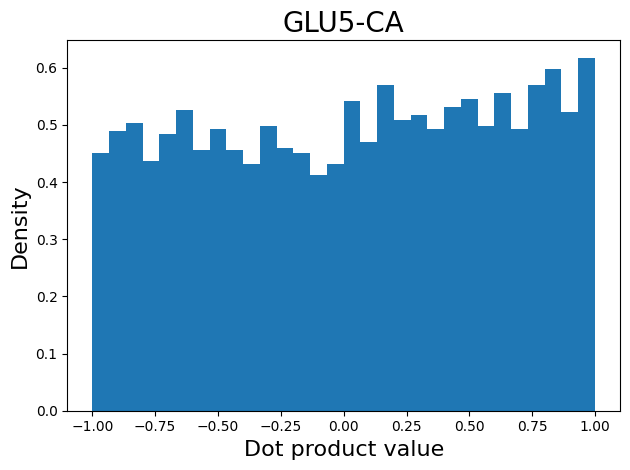

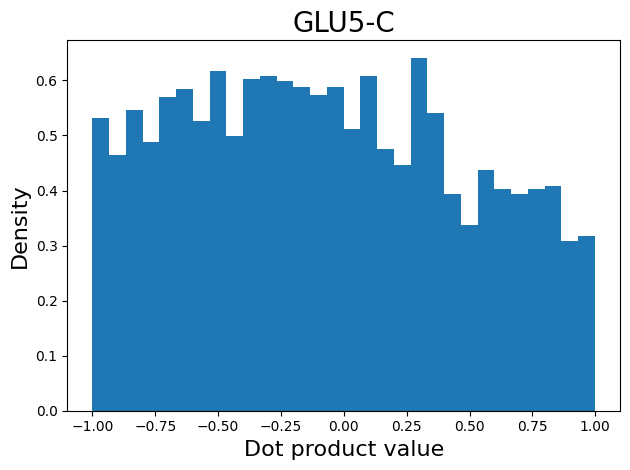

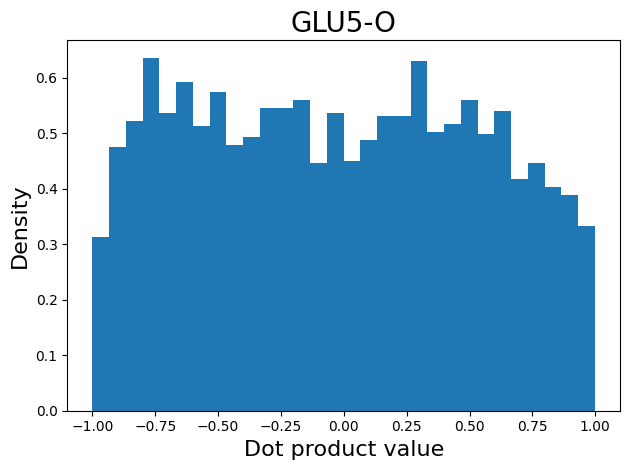

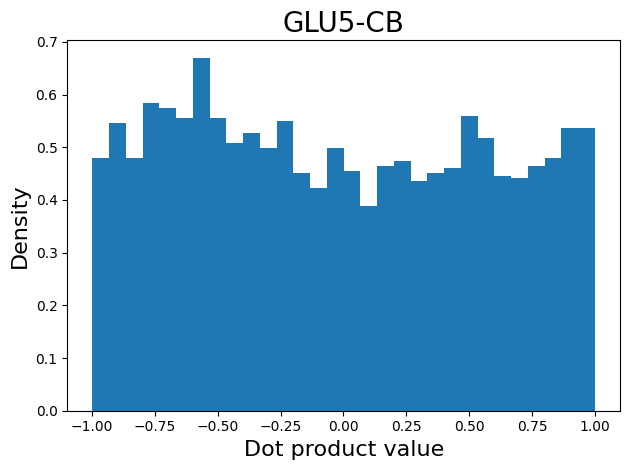

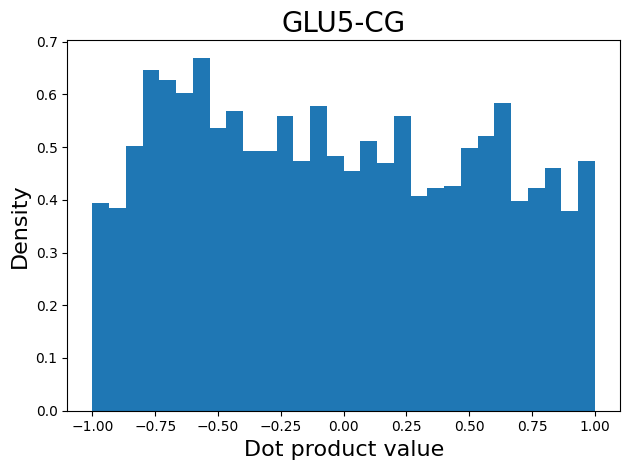

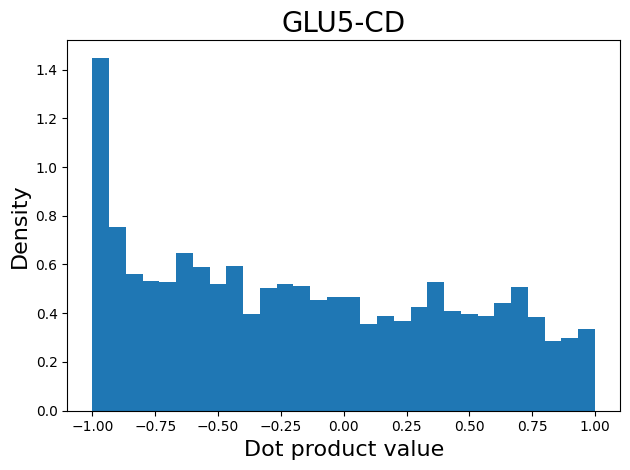

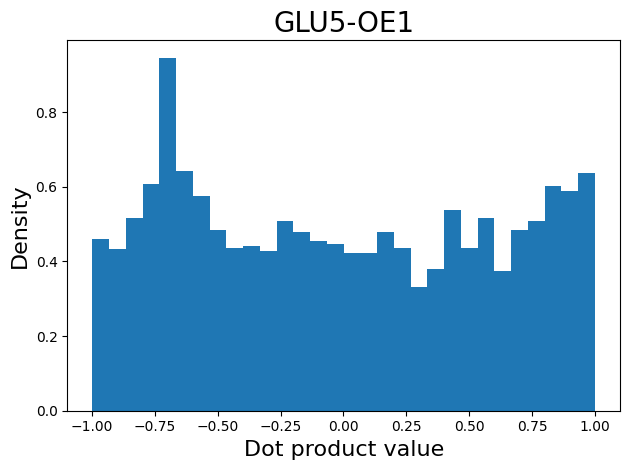

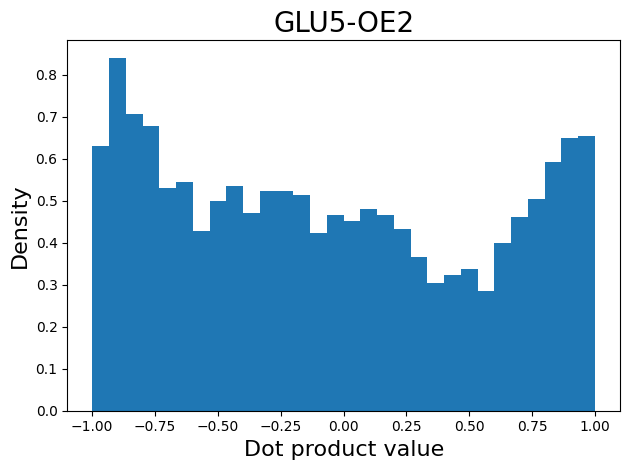

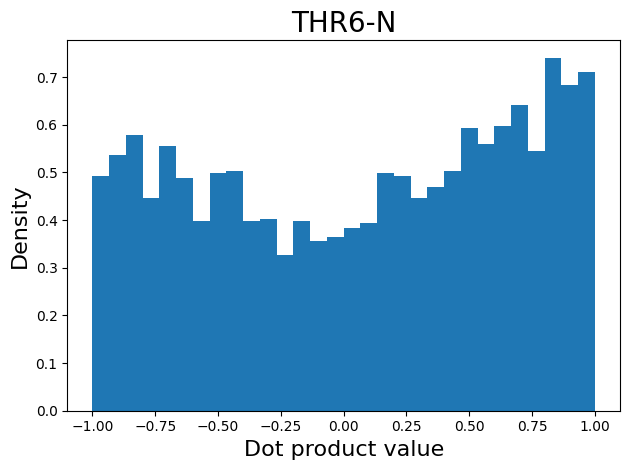

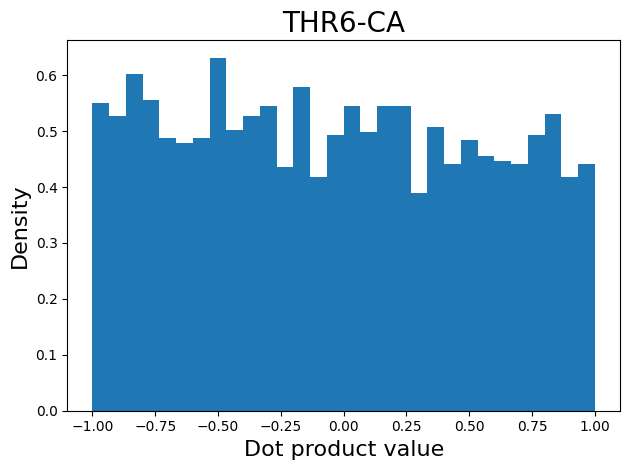

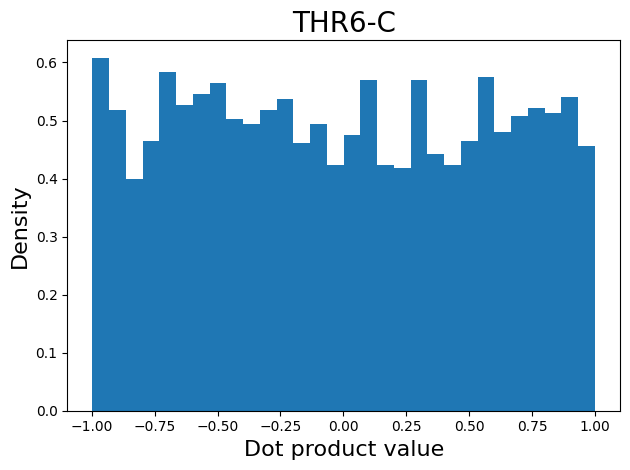

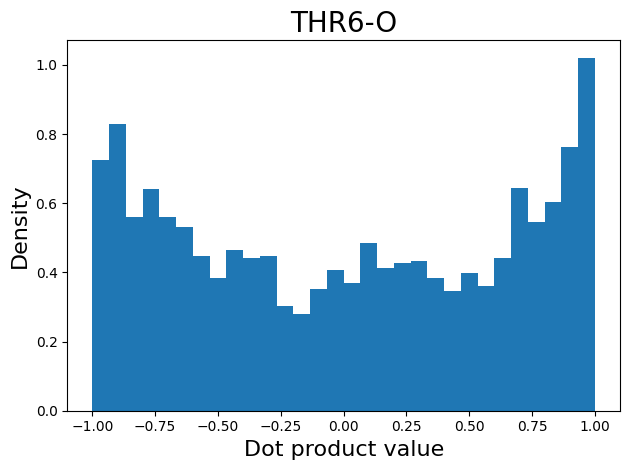

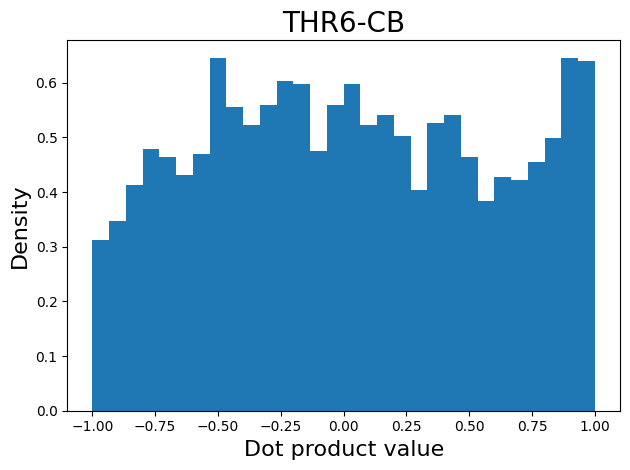

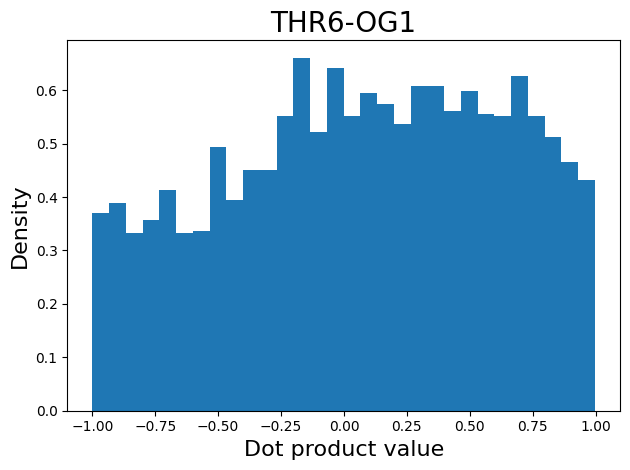

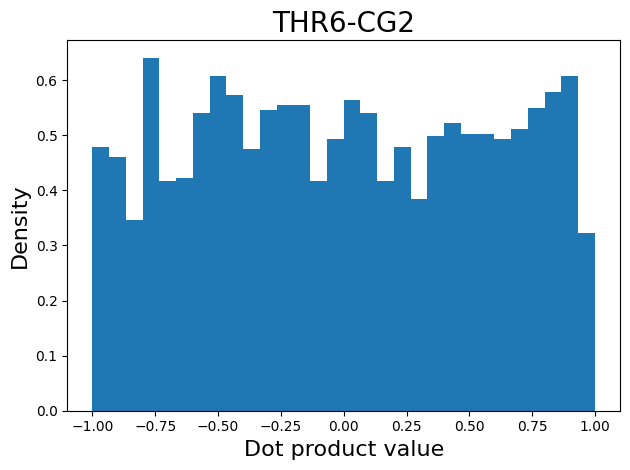

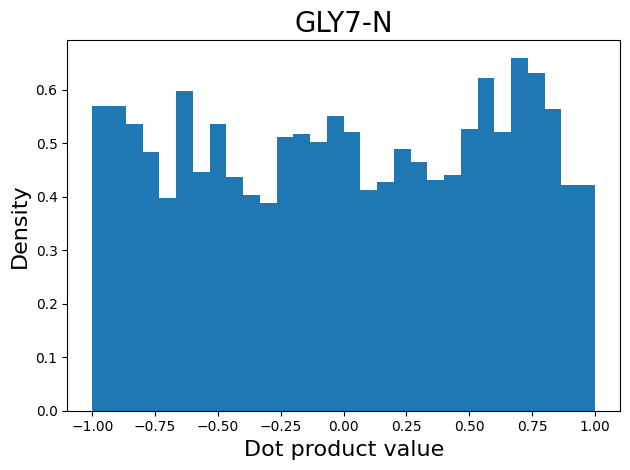

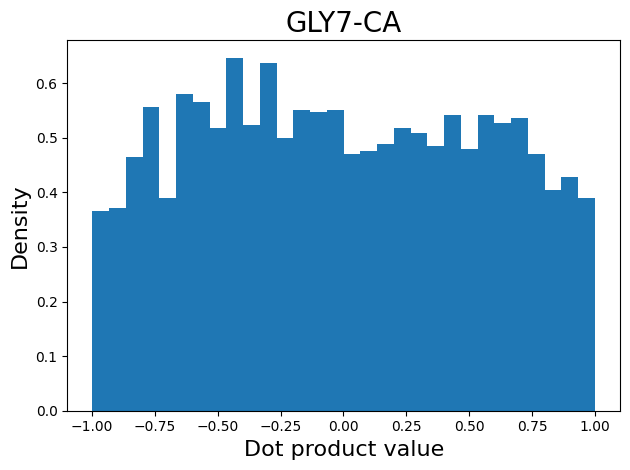

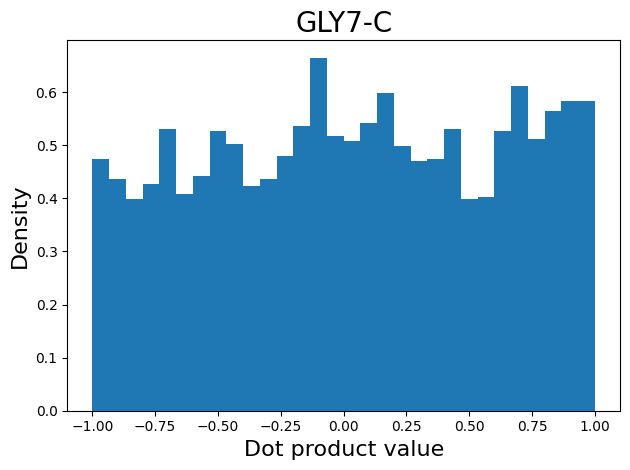

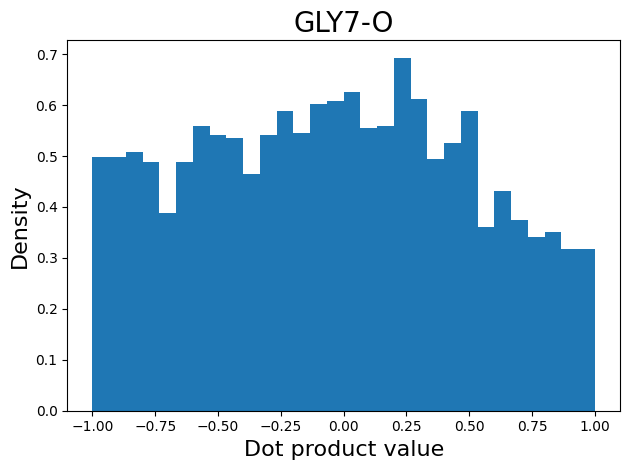

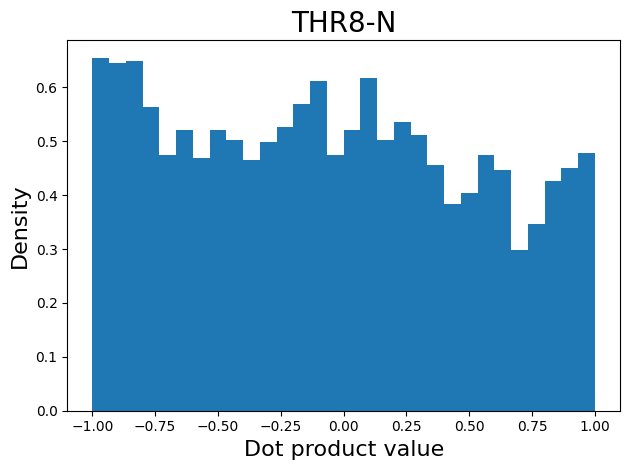

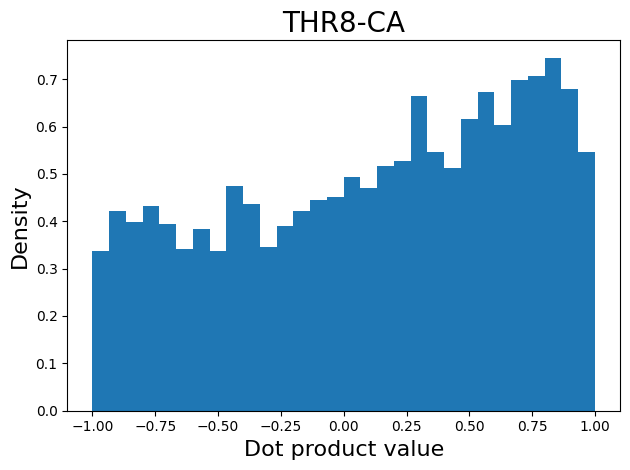

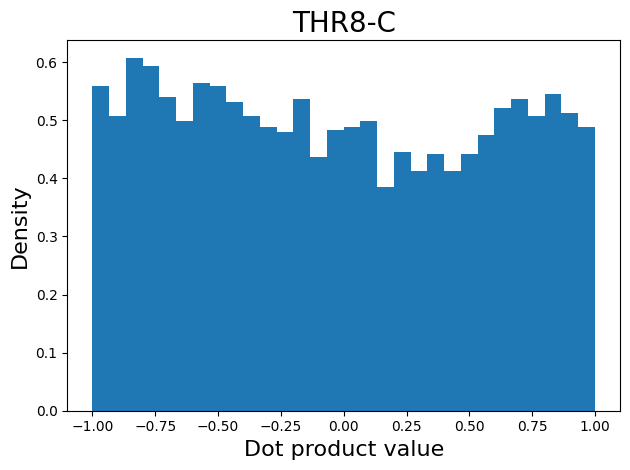

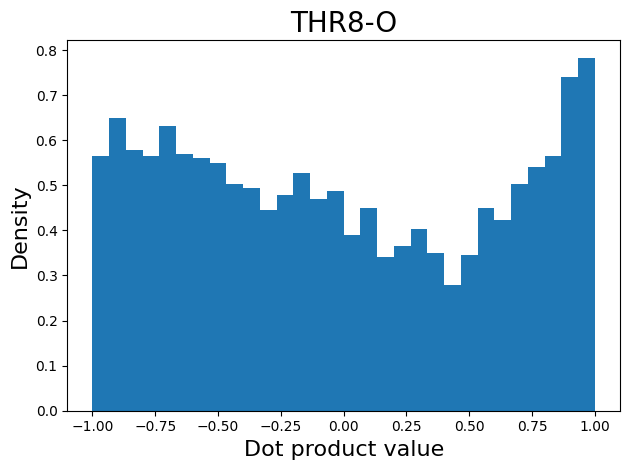

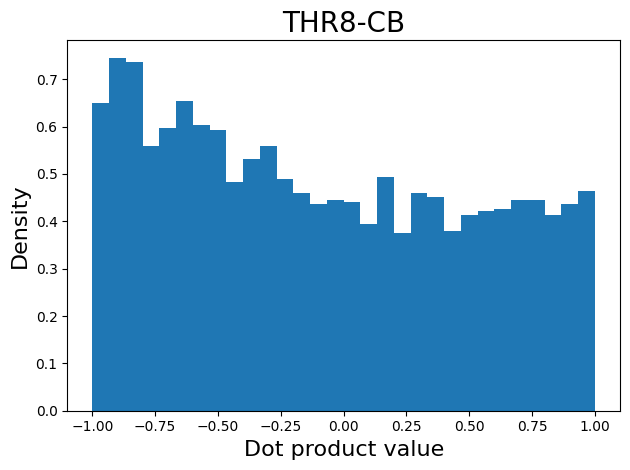

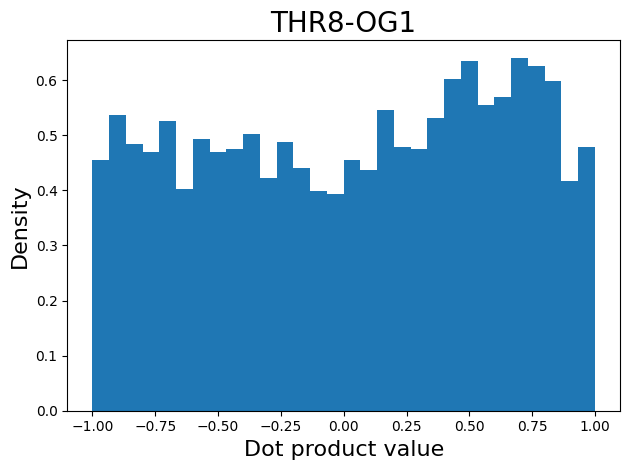

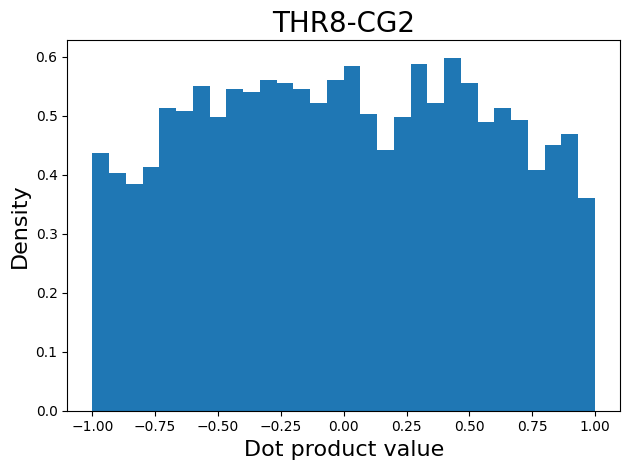

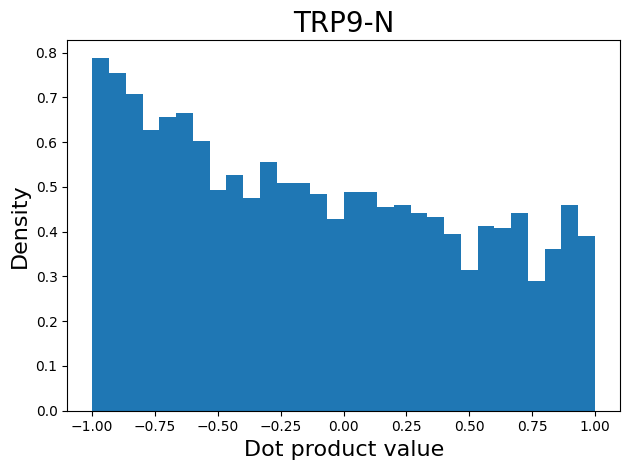

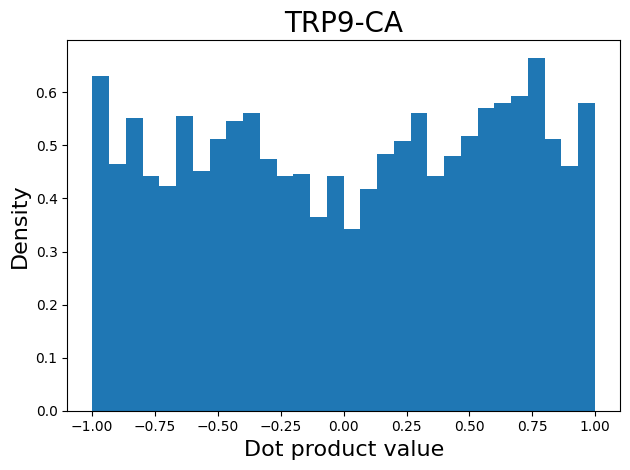

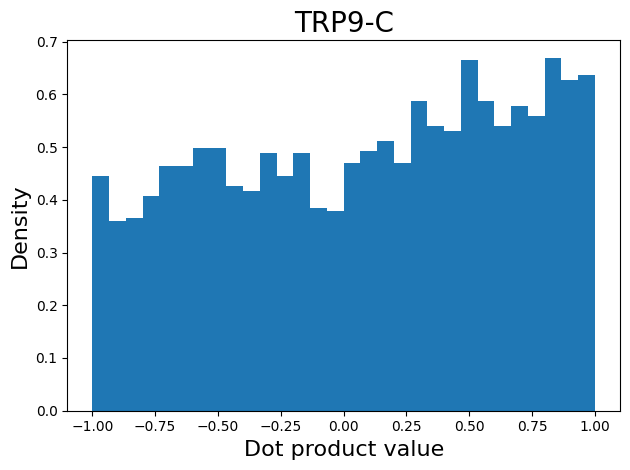

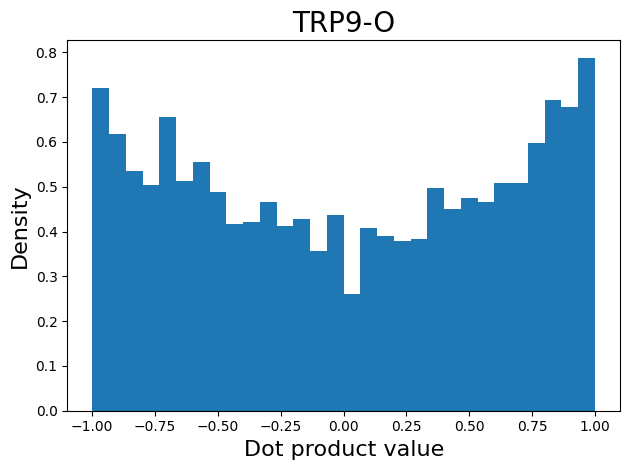

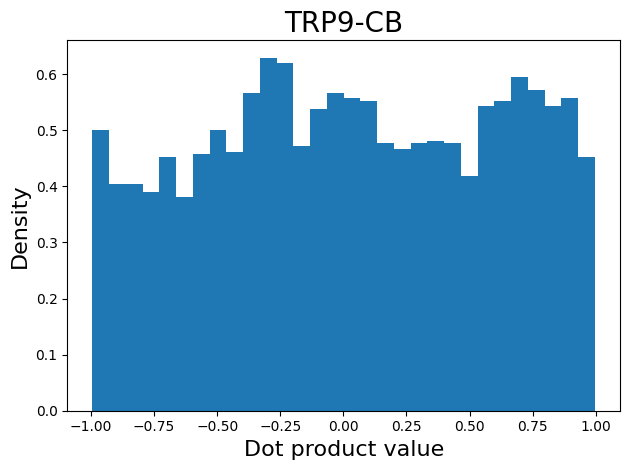

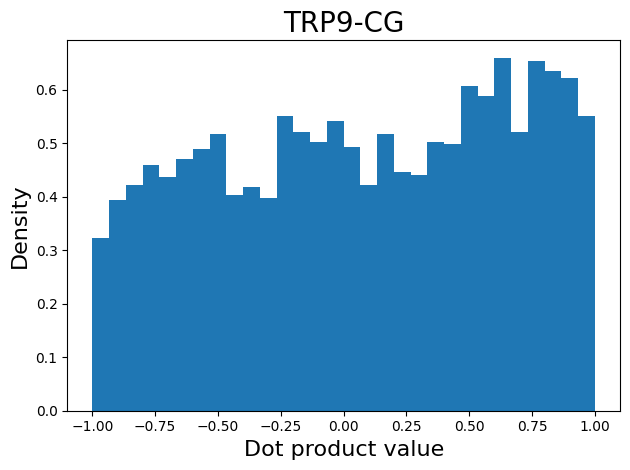

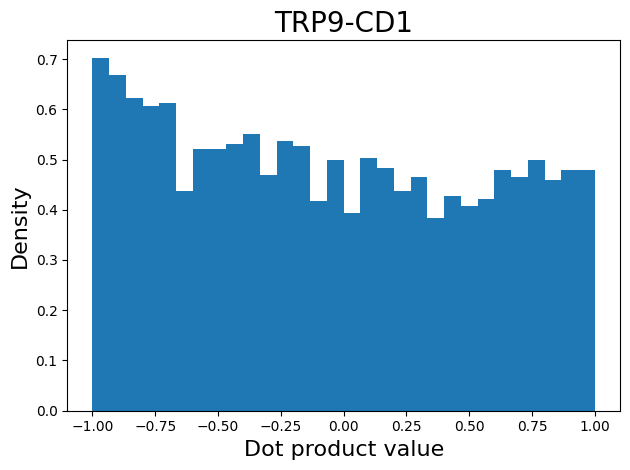

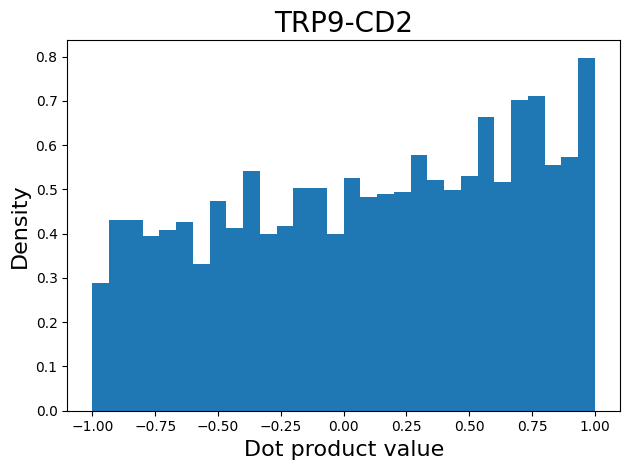

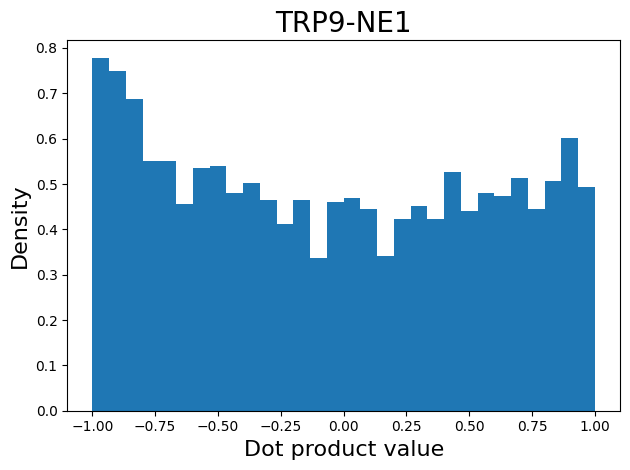

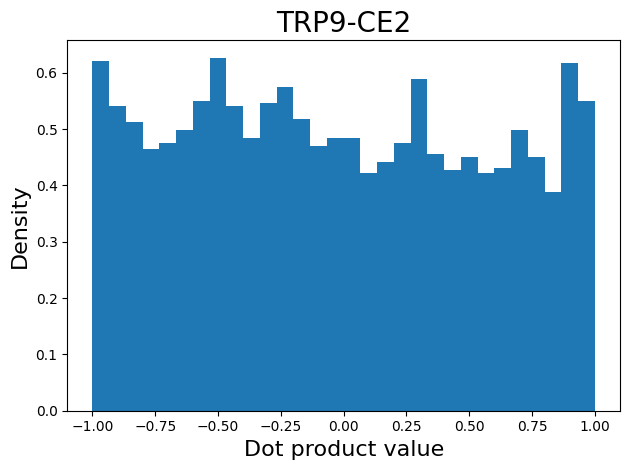

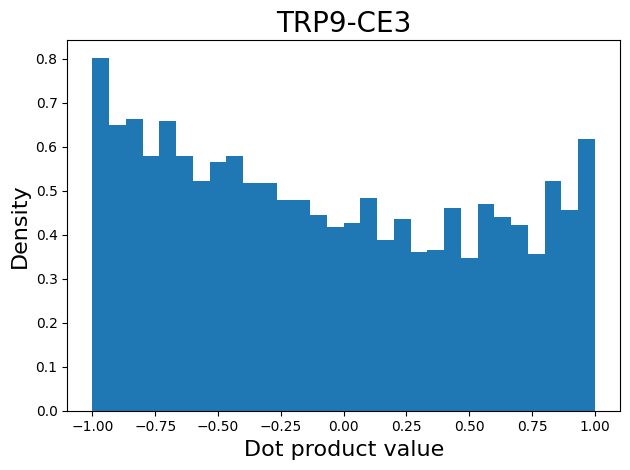

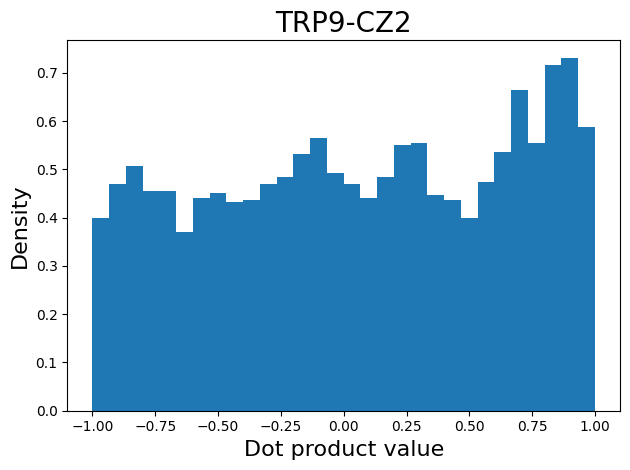

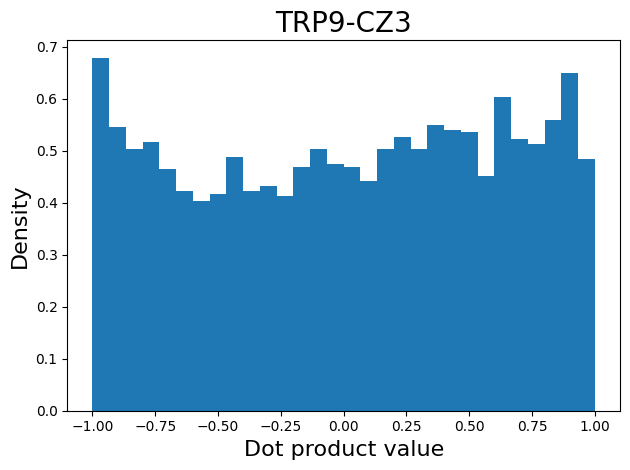

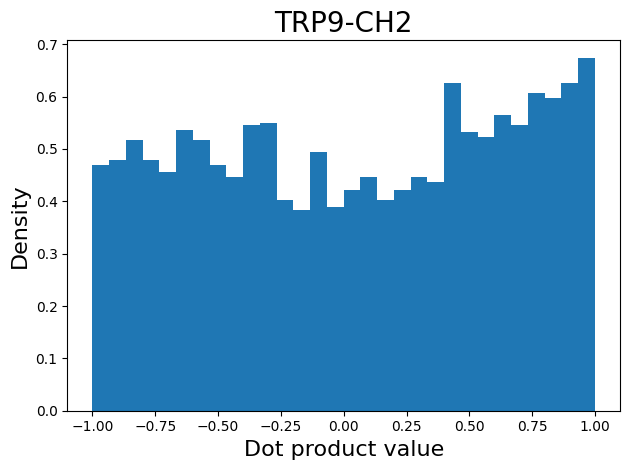

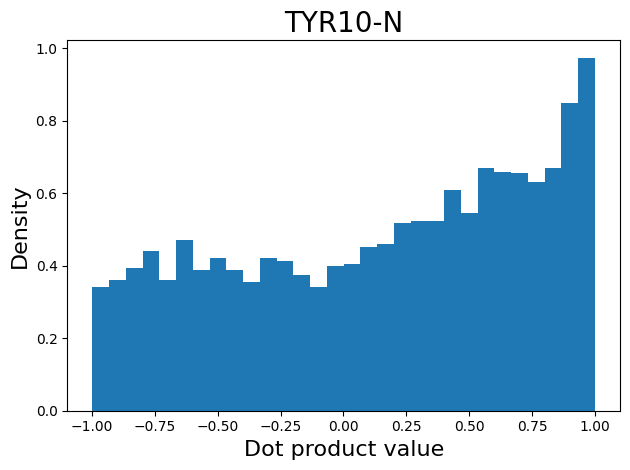

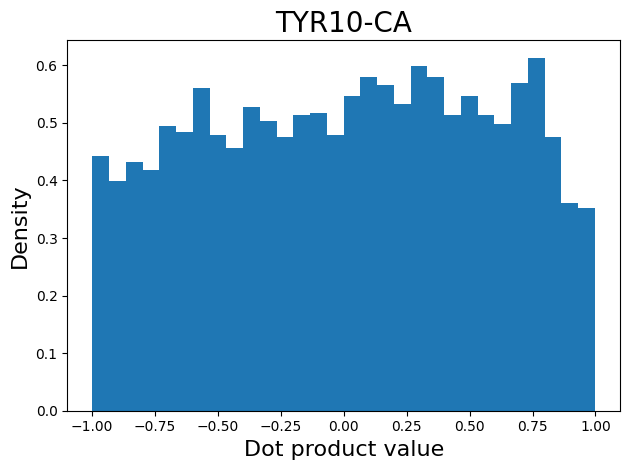

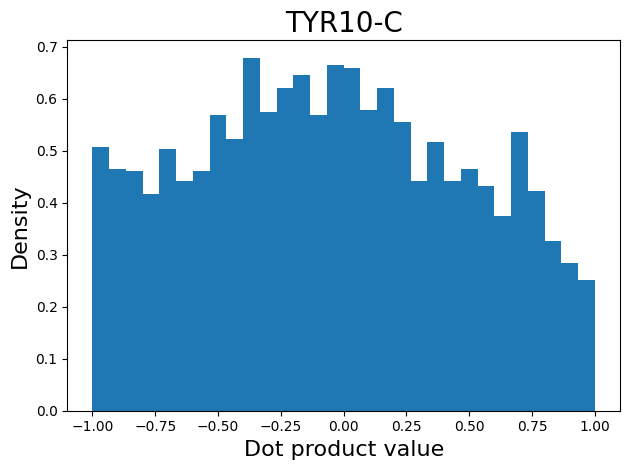

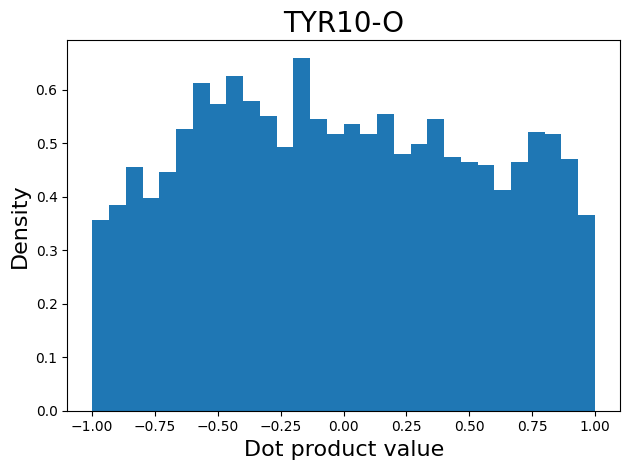

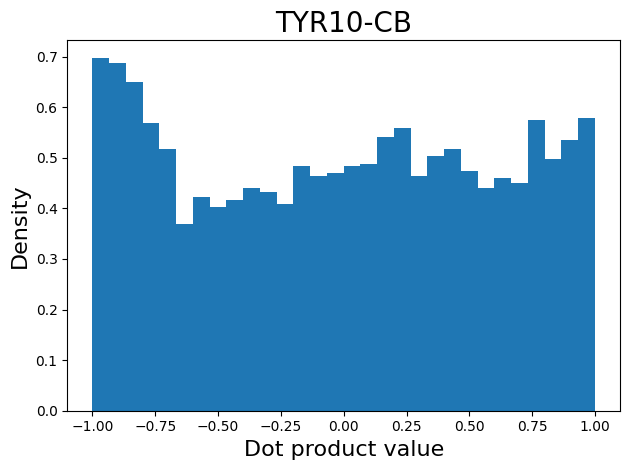

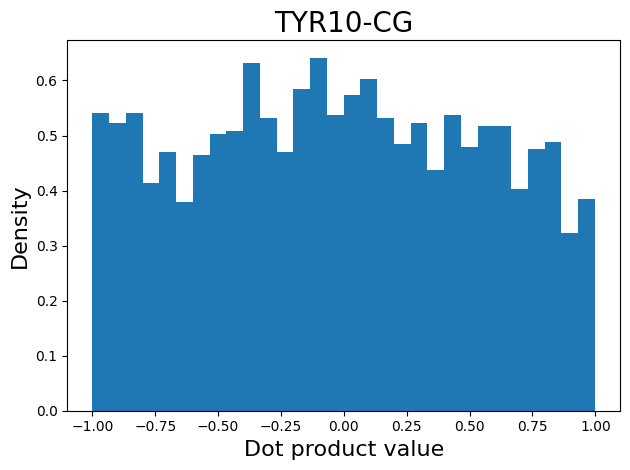

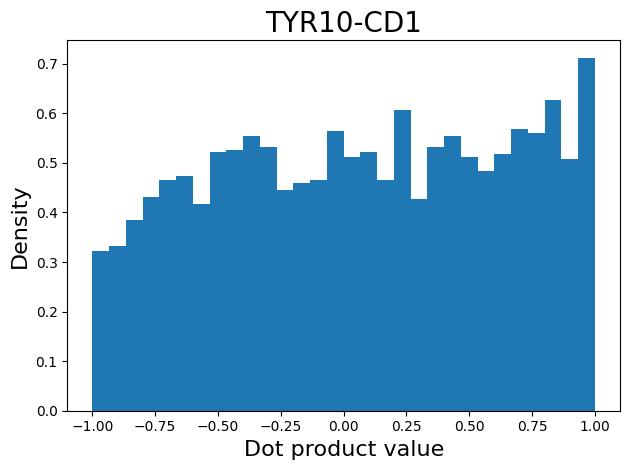

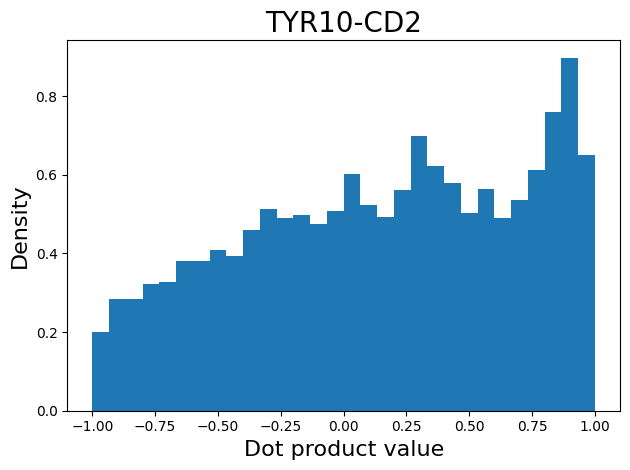

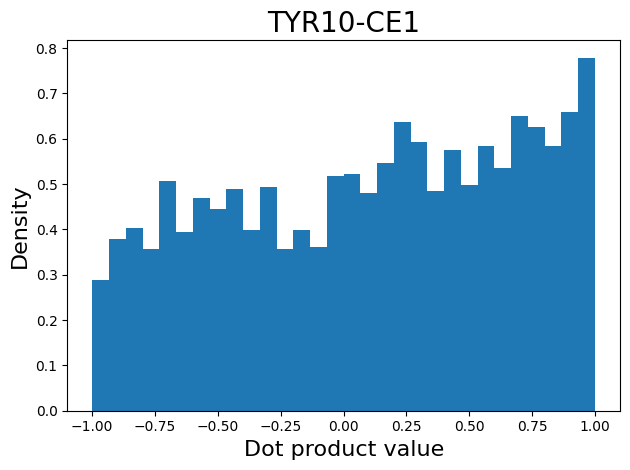

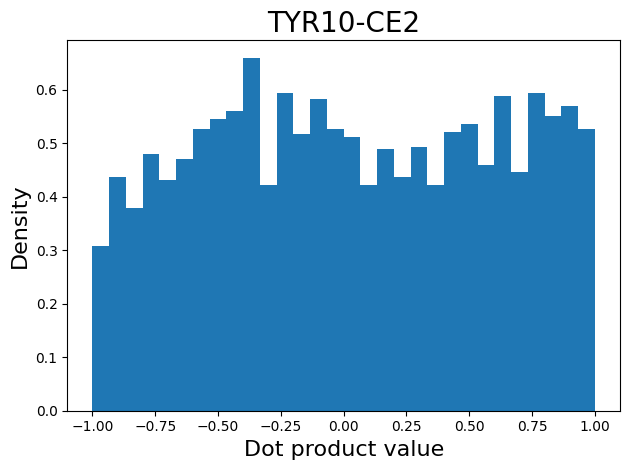

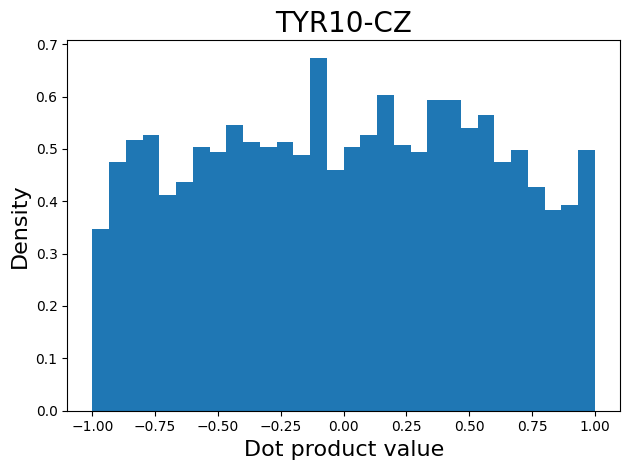

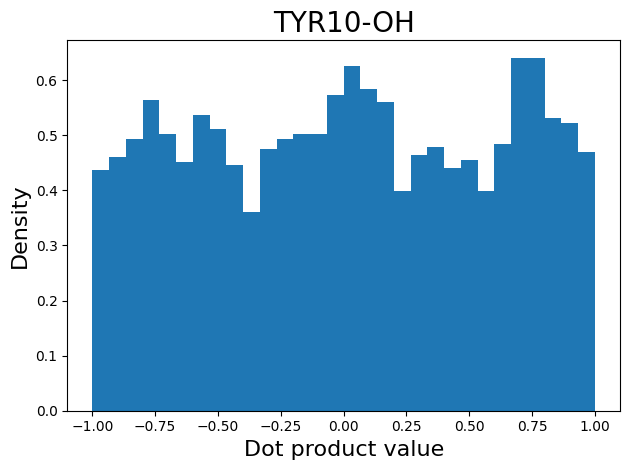

In [47]:
for i in range(dot_products.shape[1]):
    plt.hist(dot_products[:, i], bins=30, density=True)
    plt.xlabel('Dot product value', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.title(boltz_atoms[i], fontsize=20)
    plt.tight_layout()
    plt.show()

In [ ]:
print([atom for atom in fixed_traj.topology.atoms])
print([atom for atom in md_traj.topology.atoms])
print(heavy_indices)
print(heavy_forces.shape)
for i, atom in enumerate([atom for atom in fixed_traj.topology.atoms]):
    print(i, (atom in [atom for atom in md_traj.topology.atoms]))

[TYR1-N, TYR1-H, TYR1-H2, TYR1-H3, TYR1-CA, TYR1-HA, TYR1-CB, TYR1-HB2, TYR1-HB3, TYR1-CG, TYR1-CD1, TYR1-HD1, TYR1-CE1, TYR1-HE1, TYR1-CZ, TYR1-OH, TYR1-HH, TYR1-CE2, TYR1-HE2, TYR1-CD2, TYR1-HD2, TYR1-C, TYR1-O, TYR2-N, TYR2-H, TYR2-CA, TYR2-HA, TYR2-CB, TYR2-HB2, TYR2-HB3, TYR2-CG, TYR2-CD1, TYR2-HD1, TYR2-CE1, TYR2-HE1, TYR2-CZ, TYR2-OH, TYR2-HH, TYR2-CE2, TYR2-HE2, TYR2-CD2, TYR2-HD2, TYR2-C, TYR2-O, ASP3-N, ASP3-H, ASP3-CA, ASP3-HA, ASP3-CB, ASP3-HB2, ASP3-HB3, ASP3-CG, ASP3-OD1, ASP3-OD2, ASP3-C, ASP3-O, PRO4-N, PRO4-CD, PRO4-HD2, PRO4-HD3, PRO4-CG, PRO4-HG2, PRO4-HG3, PRO4-CB, PRO4-HB2, PRO4-HB3, PRO4-CA, PRO4-HA, PRO4-C, PRO4-O, GLU5-N, GLU5-H, GLU5-CA, GLU5-HA, GLU5-CB, GLU5-HB2, GLU5-HB3, GLU5-CG, GLU5-HG2, GLU5-HG3, GLU5-CD, GLU5-OE1, GLU5-OE2, GLU5-C, GLU5-O, THR6-N, THR6-H, THR6-CA, THR6-HA, THR6-CB, THR6-HB, THR6-CG2, THR6-HG21, THR6-HG22, THR6-HG23, THR6-OG1, THR6-HG1, THR6-C, THR6-O, GLY7-N, GLY7-H, GLY7-CA, GLY7-HA2, GLY7-HA3, GLY7-C, GLY7-O, THR8-N, THR8-H, THR8-CA, 

In [ ]:
pdbs = sorted(glob.glob(os.path.join(temp_dir, "frame_*_fixed.pdb")))   
print(pdbs)
traj = md.load(pdbs)
print([atom for atom in traj.topology.atoms])
print([atom for atom in md_traj.topology.atoms])

['/tmp/tmpig95rn_v/frame_0000_fixed.pdb', '/tmp/tmpig95rn_v/frame_0001_fixed.pdb', '/tmp/tmpig95rn_v/frame_0002_fixed.pdb', '/tmp/tmpig95rn_v/frame_0003_fixed.pdb', '/tmp/tmpig95rn_v/frame_0004_fixed.pdb', '/tmp/tmpig95rn_v/frame_0005_fixed.pdb', '/tmp/tmpig95rn_v/frame_0006_fixed.pdb', '/tmp/tmpig95rn_v/frame_0007_fixed.pdb', '/tmp/tmpig95rn_v/frame_0008_fixed.pdb', '/tmp/tmpig95rn_v/frame_0009_fixed.pdb', '/tmp/tmpig95rn_v/frame_0010_fixed.pdb', '/tmp/tmpig95rn_v/frame_0011_fixed.pdb', '/tmp/tmpig95rn_v/frame_0012_fixed.pdb', '/tmp/tmpig95rn_v/frame_0013_fixed.pdb', '/tmp/tmpig95rn_v/frame_0014_fixed.pdb', '/tmp/tmpig95rn_v/frame_0015_fixed.pdb', '/tmp/tmpig95rn_v/frame_0016_fixed.pdb', '/tmp/tmpig95rn_v/frame_0017_fixed.pdb', '/tmp/tmpig95rn_v/frame_0018_fixed.pdb', '/tmp/tmpig95rn_v/frame_0019_fixed.pdb', '/tmp/tmpig95rn_v/frame_0020_fixed.pdb', '/tmp/tmpig95rn_v/frame_0021_fixed.pdb', '/tmp/tmpig95rn_v/frame_0022_fixed.pdb', '/tmp/tmpig95rn_v/frame_0023_fixed.pdb', '/tmp/tmpig95rn